In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import string
import warnings
import pickle

# load video data

In [124]:
# 3d analyzed video path
camera12_analyzed_path = "/ysm-gpfs/pi/jadi/VideoTracker_SocialInter/test_video_3d/20220912_Dodson_Scorch_camera12/"
camera23_analyzed_path = "/ysm-gpfs/pi/jadi/VideoTracker_SocialInter/test_video_3d/20220912_Dodson_Scorch_camera23/"

# h5 files for the analyzed videos
camera12_h5_file = camera12_analyzed_path + "20220912_Dodson_Scorch_weikang.h5"
camera23_h5_file = camera23_analyzed_path + "20220912_Dodson_Scorch_weikang.h5"

# h5 files for save 
camera12_h5_file_save = camera12_analyzed_path + "20220912_Dodson_Scorch_weikang.h5"
camera23_h5_file_save = camera23_analyzed_path + "20220912_Dodson_Scorch_weikang.h5"

# meta pickle data for the analyzed videos
camera12_metapickle_file = camera12_analyzed_path + "20220912_Dodson_Scorch_weikang_meta.pickle"
camera23_metapickle_file = camera23_analyzed_path + "20220912_Dodson_Scorch_weikang_meta.pickle"

# load data
camera12_metapickle_data = pd.read_pickle(camera12_metapickle_file)
camera23_metapickle_data = pd.read_pickle(camera23_metapickle_file)

camera12_h5_data = pd.read_hdf(camera12_h5_file)
camera23_h5_data = pd.read_hdf(camera23_h5_file)


In [125]:
camera12_h5_data

scorer        weikang                                                    \
individuals    dodson                                                     
bodyparts   rightTuft         whiteBlaze                       leftTuft   
coords              x   y   z          x         y          z         x   
0                 NaN NaN NaN        NaN       NaN        NaN       NaN   
1                 NaN NaN NaN        NaN       NaN        NaN       NaN   
2                 NaN NaN NaN        NaN       NaN        NaN       NaN   
3                 NaN NaN NaN        NaN       NaN        NaN       NaN   
4                 NaN NaN NaN        NaN       NaN        NaN       NaN   
...               ...  ..  ..        ...       ...        ...       ...   
21109             NaN NaN NaN  -6.671821 -0.984879  10.615269 -5.609715   
21110             NaN NaN NaN  -6.457653 -1.092779  10.521489 -5.419866   
21111             NaN NaN NaN  -6.368868 -1.193823  10.481843 -5.382709   
21112             NaN NaN NaN  -6.370538 -1.200687  10.481925 -5.370077   
21113             NaN NaN NaN  -6.398517 -1.264653  10.461703 -5.425002   

scorer                                     ...                            \
individuals                                ...   scorch                    
bodyparts                        rightEye  ... leftTuft rightEye           
coords              y          z        x  ...        z        x   y   z   
0                 NaN        NaN      NaN  ...      NaN      NaN NaN NaN   
1                 NaN        NaN      NaN  ...      NaN      NaN NaN NaN   
2                 NaN        NaN      NaN  ...      NaN      NaN NaN NaN   
3                 NaN        NaN      NaN  ...      NaN      NaN NaN NaN   
4                 NaN        NaN      NaN  ...      NaN      NaN NaN NaN   
...               ...        ...      ...  ...      ...      ...  ..  ..   
21109       -1.176294  10.301602      NaN  ...      NaN      NaN NaN NaN   
21110       -1.378405  10.219523      NaN  ...      NaN      NaN NaN NaN   
21111       -1.417993  10.110538      NaN  ...      NaN      NaN NaN NaN   
21112       -1.425620  10.068949      NaN  ...      NaN      NaN NaN NaN   
21113       -1.477634  10.024297      NaN  ...      NaN      NaN NaN NaN   

scorer                                     
individuals                                
bodyparts   leftEye         mouth          
coords            x   y   z     x   y   z  
0               NaN NaN NaN   NaN NaN NaN  
1               NaN NaN NaN   NaN NaN NaN  
2               NaN NaN NaN   NaN NaN NaN  
3               NaN NaN NaN   NaN NaN NaN  
4               NaN NaN NaN   NaN NaN NaN  
...             ...  ..  ..   ...  ..  ..  
21109           NaN NaN NaN   NaN NaN NaN  
21110           NaN NaN NaN   NaN NaN NaN  
21111           NaN NaN NaN   NaN NaN NaN  
21112           NaN NaN NaN   NaN NaN NaN  
21113           NaN NaN NaN   NaN NaN NaN  

[21114 rows x 36 columns]

In [126]:
# get the fps of the analyzed video
import cv2
video_cam1_file = camera12_analyzed_path + "20220912_Dodson_Scorch_camera-1.mp4"
cam = cv2.VideoCapture(video_cam1_file)
fps1 = cam.get(cv2.CAP_PROP_FPS)
video_cam2_file = camera12_analyzed_path + "20220912_Dodson_Scorch_camera-2.mp4"
cam = cv2.VideoCapture(video_cam2_file)
fps2 = cam.get(cv2.CAP_PROP_FPS)
fps = fps1
fps

29.97002997002997

In [127]:
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used
session_start_time = 18.10 # in second
session_start_frame = session_start_time * fps # fps is 30Hz

In [128]:
# gaze angle threshold
# angle_thres = np.pi/36 # 5 degree
angle_thres = np.pi/18 # 10 degree

# analyze based on camera 1 and camera 2 

In [7]:
# analysis - camera 1 and 2
ncols = camera12_h5_data.shape[1]
nframes = camera12_h5_data.shape[0]
animal_names = []
body_parts = []
xyz_axis = []

for i in np.arange(0,ncols,1):
    animal_names.append(camera12_h5_data.columns[i][1])
    body_parts.append(camera12_h5_data.columns[i][2])
    xyz_axis.append(camera12_h5_data.columns[i][3])
  
    # fill in the nan data point
    data_point = camera12_h5_data.iloc[:,i]
    data_point_filled = data_point.interpolate(method='nearest',limit_direction='both')
    data_point_filled = data_point_filled.interpolate(method='linear',limit_direction='both')
    # smooth the data point   
    # data_point_filtered = data_point_filled.rolling(window=5, win_type='gaussian', center=True).mean(std=0.5)
    #
    # camera12_h5_data.iloc[:,i] = data_point_filled
    
animal_names_unique = pd.unique(animal_names)
print(animal_names_unique)
body_parts_unique = pd.unique(body_parts)
print(body_parts_unique)
xyz_axis_unique = pd.unique(xyz_axis)
print(xyz_axis_unique)

# camera12_h5_data.to_hdf(camera12_h5_file_save, key = "camera12_h5_data")


['dodson' 'scorch']
['rightTuft' 'whiteBlaze' 'leftTuft' 'rightEye' 'leftEye' 'mouth']
['x' 'y' 'z']


In [8]:
# find the location of each body part
body_part_locs = {}
for iname in animal_names_unique:
    for ibody in body_parts_unique:
        ind = np.isin(animal_names,iname) & np.isin(body_parts,ibody)
        body_part_locs[(iname,ibody)] = camera12_h5_data.iloc[:,ind]  
        
        # remove the outlier 
        for iaxis in np.arange(0,3,1):
            # loc_std = np.std(body_part_locs[(iname,ibody)])[iaxis]
            # loc_mean = pd.DataFrame.mean(body_part_locs[(iname,ibody)])[iaxis]
            # ind = (body_part_locs[(iname,ibody)].iloc[:,iaxis]>loc_mean+3*loc_std) | (body_part_locs[(iname,ibody)].iloc[:,iaxis]<loc_mean-3*loc_std)
            # body_part_locs[(iname,ibody)].iloc[:,iaxis][ind] = np.nan
            q1 = np.nanquantile(body_part_locs[(iname,ibody)].iloc[:,iaxis],0.25)
            q3 = np.nanquantile(body_part_locs[(iname,ibody)].iloc[:,iaxis],0.75)
            thres1 = q1 - 1.5*abs(q3-q1)
            thres2 = q3 + 1.5*abs(q3-q1)
            ind = (body_part_locs[(iname,ibody)].iloc[:,iaxis]>thres2) | (body_part_locs[(iname,ibody)].iloc[:,iaxis]<thres1)
            body_part_locs[(iname,ibody)].iloc[:,iaxis][ind] = np.nan
            
body_part_locs_camera12 = body_part_locs

In [9]:
warnings.filterwarnings('ignore')
eye_direction_camera12 = {}
eye_contact_or_not_camera12 = {}
look_at_face_or_not_camera12 = {}
for iname in animal_names_unique:
    eye_dir_frames = []
    eye_contact_frames = []
    look_at_face_frames = []
    for iframe in np.arange(0,nframes,1):
        lefteye_loc = body_part_locs[(iname,'leftEye')].iloc[iframe,:].to_numpy()
        righteye_loc = body_part_locs[(iname,'rightEye')].iloc[iframe,:].to_numpy()
        lefttuft_loc = body_part_locs[(iname,'leftTuft')].iloc[iframe,:].to_numpy()
        righttuft_loc = body_part_locs[(iname,'rightTuft')].iloc[iframe,:].to_numpy()
        whiblz_loc = body_part_locs[(iname,'whiteBlaze')].iloc[iframe,:].to_numpy()
        mouth_loc = body_part_locs[(iname,'mouth')].iloc[iframe,:].to_numpy()
        
        Vect1 = lefteye_loc - righteye_loc
        Vect2 = whiblz_loc - mouth_loc
        Vect3 = lefttuft_loc - lefteye_loc
        Vect4 = righttuft_loc - righteye_loc
        
        try:       
            Vect1 = Vect1 / scipy.linalg.norm(Vect1)
            Vect2 = Vect2 / scipy.linalg.norm(Vect2) 
        except:
            Vect1 = Vect1
            Vect2 = Vect2
        eyesight_dir = np.cross(Vect1, Vect2)
        
        if ((np.dot(eyesight_dir, Vect3)>0) | (np.dot(eyesight_dir, Vect4)>0)):
            eyesight_dir = -eyesight_dir
        
        eye_dir_frames.append(eyesight_dir)
        
        
        # examine whether this animal is looking at the other's eyes or face
        if (iname == animal_names_unique[0]): 
            iname_other = animal_names_unique[1]
        elif (iname == animal_names_unique[1]): 
            iname_other = animal_names_unique[0]
            
        lefteye_loc_other = body_part_locs[(iname_other,'leftEye')].iloc[iframe,:].to_numpy()
        righteye_loc_other = body_part_locs[(iname_other,'rightEye')].iloc[iframe,:].to_numpy()
        lefttuft_loc_other = body_part_locs[(iname_other,'leftTuft')].iloc[iframe,:].to_numpy()
        righttuft_loc_other = body_part_locs[(iname_other,'rightTuft')].iloc[iframe,:].to_numpy()
        whiblz_loc_other = body_part_locs[(iname_other,'whiteBlaze')].iloc[iframe,:].to_numpy()
        mouth_loc_other = body_part_locs[(iname_other,'mouth')].iloc[iframe,:].to_numpy()
        
        # where left eye is looking
        # vector between body part
        vect1_lefteye = lefteye_loc_other - lefteye_loc
        vect2_lefteye = righteye_loc_other - lefteye_loc
        vect3_lefteye = lefttuft_loc_other - lefteye_loc
        vect4_lefteye = righttuft_loc_other - lefteye_loc
        vect5_lefteye = whiblz_loc_other - lefteye_loc
        vect6_lefteye = mouth_loc_other - lefteye_loc
        # angle between body part vector and eyesight direction
        angle1_lefteye =  np.sign(np.dot(eyesight_dir,vect1_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_lefteye/np.linalg.norm(vect1_lefteye)), -1.0, 1.0))       
        angle2_lefteye =  np.sign(np.dot(eyesight_dir,vect2_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_lefteye/np.linalg.norm(vect2_lefteye)), -1.0, 1.0))
        angle3_lefteye =  np.sign(np.dot(eyesight_dir,vect3_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_lefteye/np.linalg.norm(vect3_lefteye)), -1.0, 1.0))
        angle4_lefteye =  np.sign(np.dot(eyesight_dir,vect4_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_lefteye/np.linalg.norm(vect4_lefteye)), -1.0, 1.0))
        angle5_lefteye =  np.sign(np.dot(eyesight_dir,vect5_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_lefteye/np.linalg.norm(vect5_lefteye)), -1.0, 1.0))
        angle6_lefteye =  np.sign(np.dot(eyesight_dir,vect6_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_lefteye/np.linalg.norm(vect6_lefteye)), -1.0, 1.0))
        
        # where right eye is looking
        # vector between body part
        vect1_righteye = lefteye_loc_other - righteye_loc
        vect2_righteye = righteye_loc_other - righteye_loc
        vect3_righteye = lefttuft_loc_other - righteye_loc
        vect4_righteye = righttuft_loc_other - righteye_loc
        vect5_righteye = whiblz_loc_other - righteye_loc
        vect6_righteye = mouth_loc_other - righteye_loc
        # angle between body part vector and eyesight direction
        angle1_righteye =  np.sign(np.dot(eyesight_dir,vect1_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_righteye/np.linalg.norm(vect1_righteye)), -1.0, 1.0))       
        angle2_righteye =  np.sign(np.dot(eyesight_dir,vect2_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_righteye/np.linalg.norm(vect2_righteye)), -1.0, 1.0))
        angle3_righteye =  np.sign(np.dot(eyesight_dir,vect3_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_righteye/np.linalg.norm(vect3_righteye)), -1.0, 1.0))
        angle4_righteye =  np.sign(np.dot(eyesight_dir,vect4_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_righteye/np.linalg.norm(vect4_righteye)), -1.0, 1.0))
        angle5_righteye =  np.sign(np.dot(eyesight_dir,vect5_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_righteye/np.linalg.norm(vect5_righteye)), -1.0, 1.0))
        angle6_righteye =  np.sign(np.dot(eyesight_dir,vect6_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_righteye/np.linalg.norm(vect6_righteye)), -1.0, 1.0))
        
        lefteye_contact_thres = ((angle1_lefteye>0)&(angle1_lefteye<angle_thres))|((angle2_lefteye>0)&(angle2_lefteye<angle_thres))
        lefteye_lookface_thres = ((angle3_lefteye>0)&(angle3_lefteye<angle_thres))|((angle4_lefteye>0)&(angle4_lefteye<angle_thres))|((angle5_lefteye>0)&(angle5_lefteye<angle_thres))|((angle6_lefteye>0)&(angle6_lefteye<angle_thres))
        righteye_contact_thres = ((angle1_righteye>0)&(angle1_righteye<angle_thres))|((angle2_righteye>0)&(angle2_righteye<angle_thres))
        righteye_lookface_thres = ((angle3_righteye>0)&(angle3_righteye<angle_thres))|((angle4_righteye>0)&(angle4_righteye<angle_thres))|((angle5_righteye>0)&(angle5_righteye<angle_thres))|((angle6_righteye>0)&(angle6_righteye<angle_thres))
        
        eye_contact_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres))
        look_at_face_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres|lefteye_lookface_thres|righteye_lookface_thres))
        
    # save to the summarized data
    eye_direction_camera12[(iname)] = eye_dir_frames
    eye_contact_or_not_camera12[(iname)] = eye_contact_frames
    look_at_face_or_not_camera12[(iname)] = look_at_face_frames
        

In [10]:
eye_direction_camera12['time_in_second'] = np.arange(0,np.shape(eye_direction_camera12['dodson'])[0],1)/30 - session_start_time
eye_contact_or_not_camera12['time_in_second'] = np.arange(0,np.shape(eye_contact_or_not_camera12['dodson'])[0],1)/30 - session_start_time
look_at_face_or_not_camera12['time_in_second'] = np.arange(0,np.shape(look_at_face_or_not_camera12['dodson'])[0],1)/30 - session_start_time

In [11]:
# sanity check
np.where(np.array(eye_contact_or_not_camera12['scorch'])==1)

(array([  172,   175,  1356,  1357,  3097,  4162,  6318,  6779, 18891]),)

In [12]:
# sanity check
np.where(np.array(eye_contact_or_not_camera12['dodson'])==1)

(array([ 6619, 13206, 13490, 15471, 20267]),)

In [13]:
# save data
with open(camera12_analyzed_path + 'body_part_locs_camera12.pkl', 'wb') as f:
    pickle.dump(body_part_locs_camera12, f)
with open(camera12_analyzed_path + 'eye_direction_camera12.pkl', 'wb') as f:
    pickle.dump(eye_direction_camera12, f)
with open(camera12_analyzed_path + 'eye_contact_or_not_camera12.pkl', 'wb') as f:
    pickle.dump(eye_contact_or_not_camera12, f)
with open(camera12_analyzed_path + 'look_at_face_or_not_camera12.pkl', 'wb') as f:
    pickle.dump(look_at_face_or_not_camera12, f)
## read
# with open(camera12_analyzed_path + 'body_part_locs_camera12.pkl', 'rb') as f:
#     data = pickle.load(f) 


# analyze based on camera 2 and camera 3 

In [14]:
# analysis - camera 2 and 3
ncols = camera23_h5_data.shape[1]
nframes = camera23_h5_data.shape[0]
animal_names = []
body_parts = []
xyz_axis = []

for i in np.arange(0,ncols,1):
    animal_names.append(camera23_h5_data.columns[i][1])
    body_parts.append(camera23_h5_data.columns[i][2])
    xyz_axis.append(camera23_h5_data.columns[i][3])
  
    # fill in the nan data point
    data_point = camera23_h5_data.iloc[:,i]
    data_point_filled = data_point.interpolate(method='nearest',limit_direction='both')
    data_point_filled = data_point_filled.interpolate(method='linear',limit_direction='both')
    # smooth the data point   
    # data_point_filtered = data_point_filled.rolling(window=5, win_type='gaussian', center=True).mean(std=0.5)
    #
    # camera23_h5_data.iloc[:,i] = data_point_filled
    
animal_names_unique = pd.unique(animal_names)
print(animal_names_unique)
body_parts_unique = pd.unique(body_parts)
print(body_parts_unique)

# camera23_h5_data.to_hdf(camera23_h5_file_save, key = "camera23_h5_data")


['dodson' 'scorch']
['rightTuft' 'whiteBlaze' 'leftTuft' 'rightEye' 'leftEye' 'mouth']


In [15]:
# find the location of each body part
body_part_locs = {}
for iname in animal_names_unique:
    for ibody in body_parts_unique:
        ind = np.isin(animal_names,iname) & np.isin(body_parts,ibody)
        body_part_locs[(iname,ibody)] = camera23_h5_data.iloc[:,ind]    
        
        # remove the outlier 
        for iaxis in np.arange(0,3,1):
            # loc_std = np.std(body_part_locs[(iname,ibody)])[iaxis]
            # loc_mean = pd.DataFrame.mean(body_part_locs[(iname,ibody)])[iaxis]
            # ind = (body_part_locs[(iname,ibody)].iloc[:,iaxis]>loc_mean+3*loc_std) | (body_part_locs[(iname,ibody)].iloc[:,iaxis]<loc_mean-3*loc_std)
            # body_part_locs[(iname,ibody)].iloc[:,iaxis][ind] = np.nan
            q1 = np.nanquantile(body_part_locs[(iname,ibody)].iloc[:,iaxis],0.25)
            q3 = np.nanquantile(body_part_locs[(iname,ibody)].iloc[:,iaxis],0.75)
            thres1 = q1 - 1.5*abs(q3-q1)
            thres2 = q3 + 1.5*abs(q3-q1)
            ind = (body_part_locs[(iname,ibody)].iloc[:,iaxis]>thres2) | (body_part_locs[(iname,ibody)].iloc[:,iaxis]<thres1)
            body_part_locs[(iname,ibody)].iloc[:,iaxis][ind] = np.nan
            
body_part_locs_camera23 = body_part_locs

In [16]:
warnings.filterwarnings('ignore')
eye_direction_camera23 = {}
eye_contact_or_not_camera23 = {}
look_at_face_or_not_camera23 = {}
for iname in animal_names_unique:
    eye_dir_frames = []
    eye_contact_frames = []
    look_at_face_frames = []
    for iframe in np.arange(0,nframes,1):
        lefteye_loc = body_part_locs[(iname,'leftEye')].iloc[iframe,:].to_numpy()
        righteye_loc = body_part_locs[(iname,'rightEye')].iloc[iframe,:].to_numpy()
        lefttuft_loc = body_part_locs[(iname,'leftTuft')].iloc[iframe,:].to_numpy()
        righttuft_loc = body_part_locs[(iname,'rightTuft')].iloc[iframe,:].to_numpy()
        whiblz_loc = body_part_locs[(iname,'whiteBlaze')].iloc[iframe,:].to_numpy()
        mouth_loc = body_part_locs[(iname,'mouth')].iloc[iframe,:].to_numpy()
        
        Vect1 = lefteye_loc - righteye_loc
        Vect2 = whiblz_loc - mouth_loc
        Vect3 = lefttuft_loc - lefteye_loc
        Vect4 = righttuft_loc - righteye_loc
        
        try:       
            Vect1 = Vect1 / scipy.linalg.norm(Vect1)
            Vect2 = Vect2 / scipy.linalg.norm(Vect2) 
        except:
            Vect1 = Vect1
            Vect2 = Vect2
        eyesight_dir = np.cross(Vect1, Vect2)
        
        if ((np.dot(eyesight_dir, Vect3)>0) | (np.dot(eyesight_dir, Vect4)>0)):
            eyesight_dir = -eyesight_dir
        
        eye_dir_frames.append(eyesight_dir)
        
        
        # examine whether this animal is looking at the other's eyes or face
        if (iname == animal_names_unique[0]): 
            iname_other = animal_names_unique[1]
        elif (iname == animal_names_unique[1]): 
            iname_other = animal_names_unique[0]
            
        lefteye_loc_other = body_part_locs[(iname_other,'leftEye')].iloc[iframe,:].to_numpy()
        righteye_loc_other = body_part_locs[(iname_other,'rightEye')].iloc[iframe,:].to_numpy()
        lefttuft_loc_other = body_part_locs[(iname_other,'leftTuft')].iloc[iframe,:].to_numpy()
        righttuft_loc_other = body_part_locs[(iname_other,'rightTuft')].iloc[iframe,:].to_numpy()
        whiblz_loc_other = body_part_locs[(iname_other,'whiteBlaze')].iloc[iframe,:].to_numpy()
        mouth_loc_other = body_part_locs[(iname_other,'mouth')].iloc[iframe,:].to_numpy()
        
        # where left eye is looking
        # vector between body part
        vect1_lefteye = lefteye_loc_other - lefteye_loc
        vect2_lefteye = righteye_loc_other - lefteye_loc
        vect3_lefteye = lefttuft_loc_other - lefteye_loc
        vect4_lefteye = righttuft_loc_other - lefteye_loc
        vect5_lefteye = whiblz_loc_other - lefteye_loc
        vect6_lefteye = mouth_loc_other - lefteye_loc
        # angle between body part vector and eyesight direction
        angle1_lefteye =  np.sign(np.dot(eyesight_dir,vect1_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_lefteye/np.linalg.norm(vect1_lefteye)), -1.0, 1.0))       
        angle2_lefteye =  np.sign(np.dot(eyesight_dir,vect2_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_lefteye/np.linalg.norm(vect2_lefteye)), -1.0, 1.0))
        angle3_lefteye =  np.sign(np.dot(eyesight_dir,vect3_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_lefteye/np.linalg.norm(vect3_lefteye)), -1.0, 1.0))
        angle4_lefteye =  np.sign(np.dot(eyesight_dir,vect4_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_lefteye/np.linalg.norm(vect4_lefteye)), -1.0, 1.0))
        angle5_lefteye =  np.sign(np.dot(eyesight_dir,vect5_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_lefteye/np.linalg.norm(vect5_lefteye)), -1.0, 1.0))
        angle6_lefteye =  np.sign(np.dot(eyesight_dir,vect6_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_lefteye/np.linalg.norm(vect6_lefteye)), -1.0, 1.0))
        
        # where right eye is looking
        # vector between body part
        vect1_righteye = lefteye_loc_other - righteye_loc
        vect2_righteye = righteye_loc_other - righteye_loc
        vect3_righteye = lefttuft_loc_other - righteye_loc
        vect4_righteye = righttuft_loc_other - righteye_loc
        vect5_righteye = whiblz_loc_other - righteye_loc
        vect6_righteye = mouth_loc_other - righteye_loc
        # angle between body part vector and eyesight direction
        angle1_righteye =  np.sign(np.dot(eyesight_dir,vect1_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_righteye/np.linalg.norm(vect1_righteye)), -1.0, 1.0))       
        angle2_righteye =  np.sign(np.dot(eyesight_dir,vect2_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_righteye/np.linalg.norm(vect2_righteye)), -1.0, 1.0))
        angle3_righteye =  np.sign(np.dot(eyesight_dir,vect3_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_righteye/np.linalg.norm(vect3_righteye)), -1.0, 1.0))
        angle4_righteye =  np.sign(np.dot(eyesight_dir,vect4_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_righteye/np.linalg.norm(vect4_righteye)), -1.0, 1.0))
        angle5_righteye =  np.sign(np.dot(eyesight_dir,vect5_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_righteye/np.linalg.norm(vect5_righteye)), -1.0, 1.0))
        angle6_righteye =  np.sign(np.dot(eyesight_dir,vect6_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_righteye/np.linalg.norm(vect6_righteye)), -1.0, 1.0))
        
        lefteye_contact_thres = ((angle1_lefteye>0)&(angle1_lefteye<angle_thres))|((angle2_lefteye>0)&(angle2_lefteye<angle_thres))
        lefteye_lookface_thres = ((angle3_lefteye>0)&(angle3_lefteye<angle_thres))|((angle4_lefteye>0)&(angle4_lefteye<angle_thres))|((angle5_lefteye>0)&(angle5_lefteye<angle_thres))|((angle6_lefteye>0)&(angle6_lefteye<angle_thres))
        righteye_contact_thres = ((angle1_righteye>0)&(angle1_righteye<angle_thres))|((angle2_righteye>0)&(angle2_righteye<angle_thres))
        righteye_lookface_thres = ((angle3_righteye>0)&(angle3_righteye<angle_thres))|((angle4_righteye>0)&(angle4_righteye<angle_thres))|((angle5_righteye>0)&(angle5_righteye<angle_thres))|((angle6_righteye>0)&(angle6_righteye<angle_thres))
        
        eye_contact_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres))
        look_at_face_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres|lefteye_lookface_thres|righteye_lookface_thres))
        
    # save to the summarized data
    eye_direction_camera23[(iname)] = eye_dir_frames
    eye_contact_or_not_camera23[(iname)] = eye_contact_frames
    look_at_face_or_not_camera23[(iname)] = look_at_face_frames
        

In [17]:
eye_direction_camera23['time_in_second'] = np.arange(0,np.shape(eye_direction_camera23['dodson'])[0],1)/30 - session_start_time
eye_contact_or_not_camera23['time_in_second'] = np.arange(0,np.shape(eye_contact_or_not_camera23['dodson'])[0],1)/30 - session_start_time
look_at_face_or_not_camera23['time_in_second'] = np.arange(0,np.shape(look_at_face_or_not_camera23['dodson'])[0],1)/30 - session_start_time

In [18]:
# sanity check
np.where(np.array(eye_contact_or_not_camera23['scorch'])==1)

(array([3067]),)

In [19]:
# sanity check
np.where(np.array(eye_contact_or_not_camera23['dodson'])==1)

(array([  785,   792,  1987,  3627,  3938,  3939,  4486,  6162,  6764,
         9036,  9037,  9038,  9039, 10718, 13174, 13175, 13201, 13204,
        13205, 13485, 13488, 14534, 14535, 14536, 14537, 14538, 14539,
        14540, 15675, 15676, 15677, 16685, 19111, 19815, 19816, 20346]),)

In [20]:
# save data
with open(camera23_analyzed_path + 'body_part_locs_camera23.pkl', 'wb') as f:
    pickle.dump(body_part_locs_camera23, f)
with open(camera23_analyzed_path + 'eye_direction_camera23.pkl', 'wb') as f:
    pickle.dump(eye_direction_camera23, f)
with open(camera23_analyzed_path + 'eye_contact_or_not_camera23.pkl', 'wb') as f:
    pickle.dump(eye_contact_or_not_camera23, f)
with open(camera23_analyzed_path + 'look_at_face_or_not_camera23.pkl', 'wb') as f:
    pickle.dump(look_at_face_or_not_camera23, f)
## read
# with open(camera23_analyzed_path + 'body_part_locs_camera23.pkl', 'rb') as f:
#     data = pickle.load(f) 


# examine the relationship between camera pairs
## make the 3d space aligned with each pair

In [129]:
# load data
try:
    ## read
    with open(camera23_analyzed_path + 'body_part_locs_camera23.pkl', 'rb') as f:
        body_part_locs_camera23 = pickle.load(f) 
    with open(camera12_analyzed_path + 'body_part_locs_camera12.pkl', 'rb') as f:
        body_part_locs_camera12 = pickle.load(f) 
except:
    print("did not save data")

In [130]:
# sanity check 
xxx = body_part_locs_camera23[('dodson','leftEye')].iloc[:,0]
yyy = body_part_locs_camera12[('dodson','leftEye')].iloc[:,0]

In [131]:
min_length = np.min([np.shape(xxx)[0],np.shape(yyy)[0]])
xxx = xxx[np.arange(0,min_length,1)]
yyy = yyy[np.arange(0,min_length,1)]

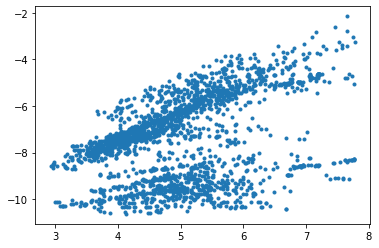

In [132]:
plt.plot(xxx,yyy,'.')

In [133]:
# try the rotation on all possible pairs
RR_sum = {}
tt_sum = {}
err_sum = {}
for iname in animal_names_unique:
    for ibody in body_parts_unique:
        xxx = body_part_locs_camera23[(iname,ibody)]
        yyy = body_part_locs_camera12[(iname,ibody)]
        min_lengh = np.min([xxx.shape[0],yyy.shape[0]])
        
        xxx = xxx.loc[np.arange(0,min_length,1),:]
        yyy = yyy.loc[np.arange(0,min_length,1),:]     
        
        ind_good = (~np.isnan(xxx.iloc[:,0]) & ~np.isnan(xxx.iloc[:,1]) & ~np.isnan(xxx.iloc[:,2])) & (~np.isnan(yyy.iloc[:,0]) & ~np.isnan(yyy.iloc[:,1]) & ~np.isnan(yyy.iloc[:,2])) 
        xxx_values = pd.DataFrame.transpose(xxx.loc[ind_good,:]).values
        yyy_values = pd.DataFrame.transpose(yyy.loc[ind_good,:]).values
        
        xxx_centroid = np.dot(np.mean(xxx_values,axis = 1).reshape(3,1), np.ones((1,np.shape(xxx_values)[1])))
        yyy_centroid = np.dot(np.mean(yyy_values,axis = 1).reshape(3,1), np.ones((1,np.shape(xxx_values)[1])))
        HH = np.dot((xxx_values - xxx_centroid), np.transpose(yyy_values - yyy_centroid))
        u, s, vh = np.linalg.svd(HH, full_matrices=True)
        RR = np.dot(np.transpose(vh),np.transpose(u))
        tt= yyy_centroid - np.dot(RR,xxx_centroid)
        tt = tt[:,1].reshape(3,1)
        
        RR_sum[(iname,ibody)] = RR
        tt_sum[(iname,ibody)] = tt
        err_sum[(iname,ibody)] = np.sum(np.square(yyy_values - (np.dot(RR,xxx_values)+np.dot(tt, np.ones((1,np.shape(xxx_values)[1]))))))

RR = RR_sum[min(err_sum, key=err_sum.get)]
tt = tt_sum[min(err_sum, key=err_sum.get)]


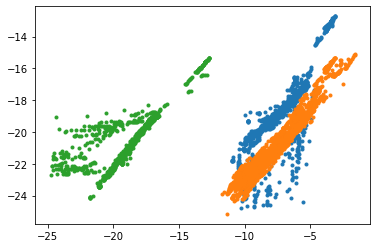

In [134]:
# sanity check
xxx_plot = np.transpose(body_part_locs_camera23[('scorch','leftTuft')].loc[np.arange(0,min_length,1),:].values)
yyy_plot = np.transpose(body_part_locs_camera12[('scorch','leftTuft')].loc[np.arange(0,min_length,1),:].values)
yyy_change = np.dot(RR,xxx_plot)
tt_change = np.dot(tt, np.ones((1,np.shape(xxx_plot)[1])))
yyy_change = np.dot(RR,xxx_plot) + tt_change
plt.plot(xxx_plot[0,:],yyy_plot[0,:],'.')
plt.plot(xxx_plot[0,:],yyy_change[0,:],'.')
plt.plot(yyy_plot[0,:],yyy_change[0,:],'.')

## merge the bhv from the two pairs of camera and redo the analysis

In [135]:
# merge the two pairs of cameras
body_part_locs_merge = {}
for iname in animal_names_unique:
    for ibody in body_parts_unique:
        RR = RR_sum[(iname,ibody)]
        tt = tt_sum[(iname,ibody)]
        body_part_x = np.transpose(body_part_locs_camera23[(iname,ibody)].loc[np.arange(0,min_length,1),:])
        body_part_project = np.transpose(np.dot(RR,body_part_x) + np.dot(tt, np.ones((1,np.shape(body_part_x)[1]))))
        body_part_origin = body_part_locs_camera12[(iname,ibody)].loc[np.arange(0,min_length,1),:].values
        body_part_origin[np.sum(np.isnan(body_part_origin),axis=1)>0,:] = body_part_project[np.sum(np.isnan(body_part_origin),axis=1)>0,:]

        body_part_locs_merge[(iname,ibody)] = body_part_origin
        

In [136]:
warnings.filterwarnings('ignore')
eye_direction_merge = {}
eye_contact_or_not_merge = {}
look_at_face_or_not_merge = {}
for iname in animal_names_unique:
    eye_dir_frames = []
    eye_contact_frames = []
    look_at_face_frames = []
    for iframe in np.arange(0,min_length,1):
        lefteye_loc = body_part_locs_merge[(iname,'leftEye')][iframe,:]
        righteye_loc = body_part_locs_merge[(iname,'rightEye')][iframe,:]
        lefttuft_loc = body_part_locs_merge[(iname,'leftTuft')][iframe,:]
        righttuft_loc = body_part_locs_merge[(iname,'rightTuft')][iframe,:]
        whiblz_loc = body_part_locs_merge[(iname,'whiteBlaze')][iframe,:]
        mouth_loc = body_part_locs_merge[(iname,'mouth')][iframe,:]
        
        Vect1 = lefteye_loc - righteye_loc
        Vect2 = whiblz_loc - mouth_loc
        Vect3 = lefttuft_loc - lefteye_loc
        Vect4 = righttuft_loc - righteye_loc
        
        try:       
            Vect1 = Vect1 / scipy.linalg.norm(Vect1)
            Vect2 = Vect2 / scipy.linalg.norm(Vect2) 
        except:
            Vect1 = Vect1
            Vect2 = Vect2
        eyesight_dir = np.cross(Vect1, Vect2)
        
        if ((np.dot(eyesight_dir, Vect3)>0) | (np.dot(eyesight_dir, Vect4)>0)):
            eyesight_dir = -eyesight_dir
        
        eye_dir_frames.append(eyesight_dir)
        
        
        # examine whether this animal is looking at the other's eyes or face
        if (iname == animal_names_unique[0]): 
            iname_other = animal_names_unique[1]
        elif (iname == animal_names_unique[1]): 
            iname_other = animal_names_unique[0]
            
        lefteye_loc_other = body_part_locs_merge[(iname_other,'leftEye')][iframe,:]
        righteye_loc_other = body_part_locs_merge[(iname_other,'rightEye')][iframe,:]
        lefttuft_loc_other = body_part_locs_merge[(iname_other,'leftTuft')][iframe,:]
        righttuft_loc_other = body_part_locs_merge[(iname_other,'rightTuft')][iframe,:]
        whiblz_loc_other = body_part_locs_merge[(iname_other,'whiteBlaze')][iframe,:]
        mouth_loc_other = body_part_locs_merge[(iname_other,'mouth')][iframe,:]
        
        # where left eye is looking
        # vector between body part
        vect1_lefteye = lefteye_loc_other - lefteye_loc
        vect2_lefteye = righteye_loc_other - lefteye_loc
        vect3_lefteye = lefttuft_loc_other - lefteye_loc
        vect4_lefteye = righttuft_loc_other - lefteye_loc
        vect5_lefteye = whiblz_loc_other - lefteye_loc
        vect6_lefteye = mouth_loc_other - lefteye_loc
        # angle between body part vector and eyesight direction
        angle1_lefteye =  np.sign(np.dot(eyesight_dir,vect1_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_lefteye/np.linalg.norm(vect1_lefteye)), -1.0, 1.0))       
        angle2_lefteye =  np.sign(np.dot(eyesight_dir,vect2_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_lefteye/np.linalg.norm(vect2_lefteye)), -1.0, 1.0))
        angle3_lefteye =  np.sign(np.dot(eyesight_dir,vect3_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_lefteye/np.linalg.norm(vect3_lefteye)), -1.0, 1.0))
        angle4_lefteye =  np.sign(np.dot(eyesight_dir,vect4_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_lefteye/np.linalg.norm(vect4_lefteye)), -1.0, 1.0))
        angle5_lefteye =  np.sign(np.dot(eyesight_dir,vect5_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_lefteye/np.linalg.norm(vect5_lefteye)), -1.0, 1.0))
        angle6_lefteye =  np.sign(np.dot(eyesight_dir,vect6_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_lefteye/np.linalg.norm(vect6_lefteye)), -1.0, 1.0))
        
        # where right eye is looking
        # vector between body part
        vect1_righteye = lefteye_loc_other - righteye_loc
        vect2_righteye = righteye_loc_other - righteye_loc
        vect3_righteye = lefttuft_loc_other - righteye_loc
        vect4_righteye = righttuft_loc_other - righteye_loc
        vect5_righteye = whiblz_loc_other - righteye_loc
        vect6_righteye = mouth_loc_other - righteye_loc
        # angle between body part vector and eyesight direction
        angle1_righteye =  np.sign(np.dot(eyesight_dir,vect1_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_righteye/np.linalg.norm(vect1_righteye)), -1.0, 1.0))       
        angle2_righteye =  np.sign(np.dot(eyesight_dir,vect2_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_righteye/np.linalg.norm(vect2_righteye)), -1.0, 1.0))
        angle3_righteye =  np.sign(np.dot(eyesight_dir,vect3_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_righteye/np.linalg.norm(vect3_righteye)), -1.0, 1.0))
        angle4_righteye =  np.sign(np.dot(eyesight_dir,vect4_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_righteye/np.linalg.norm(vect4_righteye)), -1.0, 1.0))
        angle5_righteye =  np.sign(np.dot(eyesight_dir,vect5_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_righteye/np.linalg.norm(vect5_righteye)), -1.0, 1.0))
        angle6_righteye =  np.sign(np.dot(eyesight_dir,vect6_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_righteye/np.linalg.norm(vect6_righteye)), -1.0, 1.0))
        
        lefteye_contact_thres = ((angle1_lefteye>0)&(angle1_lefteye<angle_thres))|((angle2_lefteye>0)&(angle2_lefteye<angle_thres))
        lefteye_lookface_thres = ((angle3_lefteye>0)&(angle3_lefteye<angle_thres))|((angle4_lefteye>0)&(angle4_lefteye<angle_thres))|((angle5_lefteye>0)&(angle5_lefteye<angle_thres))|((angle6_lefteye>0)&(angle6_lefteye<angle_thres))
        righteye_contact_thres = ((angle1_righteye>0)&(angle1_righteye<angle_thres))|((angle2_righteye>0)&(angle2_righteye<angle_thres))
        righteye_lookface_thres = ((angle3_righteye>0)&(angle3_righteye<angle_thres))|((angle4_righteye>0)&(angle4_righteye<angle_thres))|((angle5_righteye>0)&(angle5_righteye<angle_thres))|((angle6_righteye>0)&(angle6_righteye<angle_thres))
        
        eye_contact_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres))
        look_at_face_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres|lefteye_lookface_thres|righteye_lookface_thres))
        
    # save to the summarized data
    eye_direction_merge[(iname)] = eye_dir_frames
    eye_contact_or_not_merge[(iname)] = eye_contact_frames
    look_at_face_or_not_merge[(iname)] = look_at_face_frames
        

In [137]:
eye_direction_merge['time_in_second'] = np.arange(0,np.shape(eye_direction_merge['dodson'])[0],1)/30 - session_start_time
eye_contact_or_not_merge['time_in_second'] = np.arange(0,np.shape(eye_contact_or_not_merge['dodson'])[0],1)/30 - session_start_time
look_at_face_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_face_or_not_merge['dodson'])[0],1)/30 - session_start_time

## load behavioral results

In [138]:
# load behavioral results
try:
    bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/20220912_Dodson_Scorch/"
    trial_record_json = bhv_data_path + "20220912_Scorch_Dodson_TrialRecord_1.json"
    bhv_data_json = bhv_data_path + "20220912_Scorch_Dodson_bhv_data_1.json"
    session_info_json = bhv_data_path + "20220912_Scorch_Dodson_session_info_1.json"
    #
    trial_record = pd.read_json(trial_record_json)
    bhv_data = pd.read_json(bhv_data_json)
    session_info = pd.read_json(session_info_json)
except:
    bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/20220912_Dodson_Scorch/"
    trial_record_json = bhv_data_path + "20220912_Dodson_Scorch_TrialRecord_1.json"
    bhv_data_json = bhv_data_path + "20220912_Dodson_Scorch_bhv_data_1.json"
    session_info_json = bhv_data_path + "20220912_Dodson_Scorch_session_info_1.json"
    #
    trial_record = pd.read_json(trial_record_json)
    bhv_data = pd.read_json(bhv_data_json)
    session_info = pd.read_json(session_info_json)

In [139]:
animal1 = session_info['lever1_animal'][0].lower()
animal2 = session_info['lever2_animal'][0].lower()

In [140]:
# clean up the trial_record
warnings.filterwarnings('ignore')
trial_record_clean = pd.DataFrame(columns=trial_record.columns)
for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
    # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
    trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
trial_record_clean = trial_record_clean.reset_index(drop = True)

In [141]:
# change bhv_data time to the absolute time
time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
    ind = bhv_data["trial_number"]==itrial+1
    new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
    time_points_new["time_points_new"][ind] = new_time_itrial
bhv_data["time_points"] = time_points_new["time_points_new"]

## plot behavioral results (with camera pair merged) and eye contact results

In [142]:
time_point_pull1 = bhv_data["time_points"][bhv_data["behavior_events"]==1]
time_point_pull2 = bhv_data["time_points"][bhv_data["behavior_events"]==2]
ind_lookatotherface1 = np.where(np.array(look_at_face_or_not_merge[animal1])==1)
time_point_lookatotherface1 = look_at_face_or_not_merge["time_in_second"][ind_lookatotherface1]
ind_lookatotherface2 = np.where(np.array(look_at_face_or_not_merge[animal2])==1)
time_point_lookatotherface2 = look_at_face_or_not_merge["time_in_second"][ind_lookatotherface2]

ind_eyecontact1 = np.where(np.array(eye_contact_or_not_merge[animal1])==1)
time_point_eyecontact1 = eye_contact_or_not_merge["time_in_second"][ind_eyecontact1]
ind_eyecontact2 = np.where(np.array(eye_contact_or_not_merge[animal2])==1)
time_point_eyecontact2 = eye_contact_or_not_merge["time_in_second"][ind_eyecontact2]

# calculate the oneway gaze or mutual gaze
animal1_gaze = np.round(np.concatenate((time_point_eyecontact1,time_point_lookatotherface1)),1)
animal1_gaze = np.unique(np.sort(animal1_gaze))
animal2_gaze = np.round(np.concatenate((time_point_eyecontact2,time_point_lookatotherface2)),1)
animal2_gaze = np.unique(np.sort(animal2_gaze))

ngaze1 = len(animal1_gaze)
ngaze2 = len(animal2_gaze)
oneway_gaze1 = []
oneway_gaze2 = []
mutual_gaze1 = []
mutual_gaze2 = []
# 
for igaze1 in np.arange(0, ngaze1, 1):
    for igaze2 in np.arange(0,ngaze2,1):
        if abs(animal1_gaze[igaze1]-animal2_gaze[igaze2])<1:
            mutual_gaze1.append(animal1_gaze[igaze1])
            mutual_gaze2.append(animal2_gaze[igaze2])
mutual_gaze1 = np.unique(mutual_gaze1)   
mutual_gaze2 = np.unique(mutual_gaze2)
oneway_gaze1 = animal1_gaze[~np.isin(animal1_gaze,mutual_gaze1)]
oneway_gaze2 = animal2_gaze[~np.isin(animal2_gaze,mutual_gaze2)]

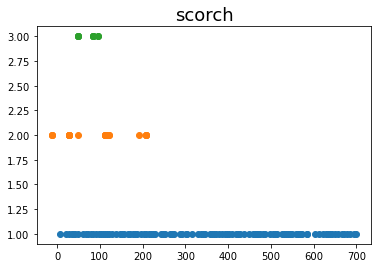

In [143]:
time_point_pull1 = np.round(time_point_pull1,2)
ind_plot = time_point_pull1 < (720 - session_start_time)
plt.plot(time_point_pull1[ind_plot], np.ones(np.shape(time_point_pull1[ind_plot])[0]),'o')
plt.plot(oneway_gaze1, np.ones(np.shape(oneway_gaze1)[0])*2,'o')
plt.plot(mutual_gaze1, np.ones(np.shape(mutual_gaze1)[0])*3,'o')
plt.title(animal1,fontsize = 18);

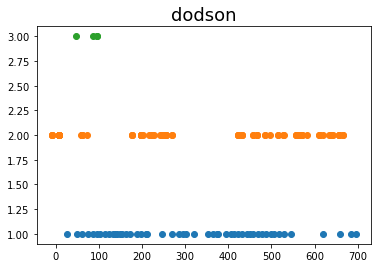

In [144]:
time_point_pull2 = np.round(time_point_pull2,2)
ind_plot = time_point_pull2 < (720 - session_start_time)
plt.plot(time_point_pull2[ind_plot], np.ones(np.shape(time_point_pull2[ind_plot])[0]),'o')
plt.plot(oneway_gaze2, np.ones(np.shape(oneway_gaze2)[0])*2,'o')
plt.plot(mutual_gaze2, np.ones(np.shape(mutual_gaze2)[0])*3,'o')
plt.title(animal2,fontsize = 18);

In [145]:
(mutual_gaze1+session_start_time)/60

array([1.09833333, 1.1       , 1.10166667, 1.10333333, 1.715     ,
       1.71666667, 1.71833333, 1.72      , 1.89      , 1.89166667])

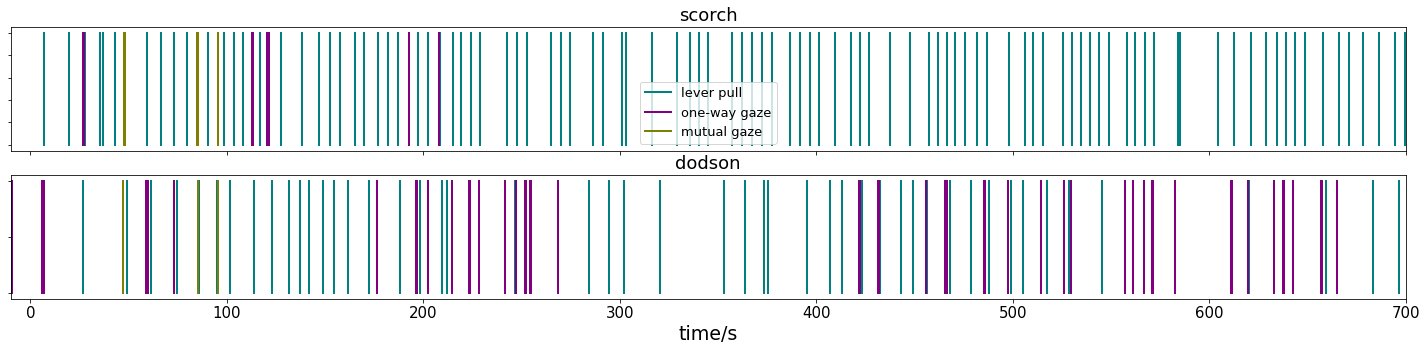

In [146]:
fig, axs = plt.subplots(2,1)
fig.set_figheight(5)
fig.set_figwidth(25)
# plot for animal 1
ind_plot = time_point_pull1 < (720 - session_start_time)
#for itime in np.arange(0,720,1):
#    plt.plot([itime,itime],[0,1],linewidth = 2.0,color=(0.5,0.5,0.5))
for itime in time_point_pull1[ind_plot]:
    line1, = axs[0].plot([itime,itime],[0,1],linewidth = 2.0,color=(0.0,0.5,0.5),label = 'lever pull')
for itime in oneway_gaze1:
    line2, = axs[0].plot([itime,itime],[0,1],linewidth = 2.0,color=(0.5,0.0,0.5),label = 'one-way gaze')  
try:
    for itime in mutual_gaze1:
        line3, = axs[0].plot([itime,itime],[0,1],linewidth = 2.0,color=(0.5,0.5,0.0),label = 'mutual gaze')  
except:
    print("no mutual gaze")
axs[0].set_title(animal1,fontsize = 18)
axs[0].set_xlim([-10,700])
axs[0].set_xlabel("")
axs[0].set_xticklabels("")
axs[0].set_yticklabels("")
try:
    axs[0].legend(handles=[line1,line2,line3], fontsize = 13)
except:
    axs[0].legend(handles=[line1,line2], fontsize = 13)

# plot for animal 2
ind_plot = time_point_pull2 < (720 - session_start_time)
#for itime in np.arange(0,720,1):
#    plt.plot([itime,itime],[0,1],linewidth = 2.0,color=(0.5,0.5,0.5))
for itime in time_point_pull2[ind_plot]:
    line1, = axs[1].plot([itime,itime],[0,1],linewidth = 2.0,color=(0.0,0.5,0.5))
for itime in oneway_gaze2:
    line2, = axs[1].plot([itime,itime],[0,1],linewidth = 2.0,color=(0.5,0.0,0.5))    
try:
    for itime in mutual_gaze2:
        line3, = axs[1].plot([itime,itime],[0,1],linewidth = 2.0,color=(0.5,0.5,0.0))    
except:
    print("no mutual gaze")
axs[1].set_title(animal2,fontsize = 18)
axs[1].set_xlim([-10,700])
axs[1].set_xlabel("time/s",fontsize = 19)
axs[1].set_yticklabels("")
axs[1].tick_params(labelsize = 15)

plt.savefig("20220912_DS_pattern.png")


## train the dynamic bayesian network

In [147]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
import networkx as nx

[<TabularCPD representing P((pull1, 0):2) at 0x2afd1a97fd90>,
 <TabularCPD representing P((owgaze2, 0):2) at 0x2afd1a97f850>,
 <TabularCPD representing P((owgaze1, 0):2) at 0x2afd19dd0250>,
 <TabularCPD representing P((pull2, 0):2) at 0x2afd1a544250>,
 <TabularCPD representing P((pull1, 1):2 | (owgaze1, 0):2) at 0x2afd1a3b81c0>,
 <TabularCPD representing P((owgaze2, 1):2 | (pull2, 0):2) at 0x2afd2103ae20>,
 <TabularCPD representing P((owgaze1, 1):2 | (pull1, 0):2) at 0x2afd1a97ffa0>,
 <TabularCPD representing P((pull2, 1):2 | (owgaze2, 0):2) at 0x2afd1a708070>]

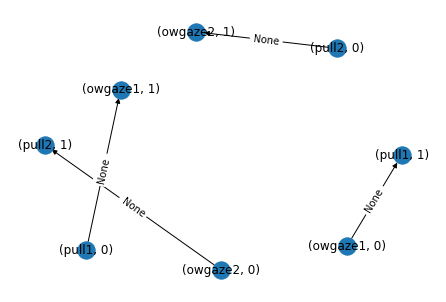

In [148]:
# real data
total_time = int(720 - session_start_time) * 2
# round to 0.5s
time_point_pull1_round = round(time_point_pull1 * 2).reset_index(drop = True).astype(int)
time_point_pull1_round = time_point_pull1_round[time_point_pull1_round<total_time]
time_point_pull2_round  = round(time_point_pull2 * 2).reset_index(drop = True).astype(int)
time_point_pull2_round = time_point_pull2_round[time_point_pull2_round<total_time]
time_point_onewaygaze1_round = round(pd.Series(oneway_gaze1)*2).reset_index(drop = True).astype(int)
time_point_onewaygaze2_round = round(pd.Series(oneway_gaze2)*2).reset_index(drop = True).astype(int)
time_point_mutualgaze1_round = round(pd.Series(mutual_gaze1)*2).reset_index(drop = True).astype(int)
time_point_mutualgaze2_round = round(pd.Series(mutual_gaze2)*2).reset_index(drop = True).astype(int)
time_point_onewaygaze1_round = time_point_onewaygaze1_round[time_point_onewaygaze1_round>0]
time_point_onewaygaze2_round = time_point_onewaygaze2_round[time_point_onewaygaze2_round>0]
time_point_mutualgaze1_round = time_point_mutualgaze1_round[time_point_mutualgaze1_round>0]
time_point_mutualgaze2_round = time_point_mutualgaze2_round[time_point_mutualgaze2_round>0]
# t0
pull1_t0 = np.zeros((total_time,1))
pull1_t0[np.array(time_point_pull1_round)] = 1
pull2_t0 = np.zeros((total_time,1))
pull2_t0[np.array(time_point_pull2_round)] = 1
owgaze1_t0 = np.zeros((total_time,1))
owgaze1_t0[np.array(time_point_onewaygaze1_round)] = 1
owgaze2_t0 = np.zeros((total_time,1))
owgaze2_t0[np.array(time_point_onewaygaze2_round)] = 1
mtgaze1_t0 = np.zeros((total_time,1))
mtgaze1_t0[np.array(time_point_mutualgaze1_round)] = 1
mtgaze2_t0 = np.zeros((total_time,1))
mtgaze2_t0[np.array(time_point_mutualgaze2_round)] = 1
# t1
pull1_t1 = np.zeros((total_time,1))
pull1_t1[np.array(time_point_pull1_round)+1] = 1
pull2_t1 = np.zeros((total_time,1))
pull2_t1[np.array(time_point_pull2_round)+1] = 1
owgaze1_t1 = np.zeros((total_time,1))
owgaze1_t1[np.array(time_point_onewaygaze1_round)+1] = 1
owgaze2_t1 = np.zeros((total_time,1))
owgaze2_t1[np.array(time_point_onewaygaze2_round)+1] = 1
mtgaze1_t1 = np.zeros((total_time,1))
mtgaze1_t1[np.array(time_point_mutualgaze1_round)+1] = 1
mtgaze2_t1 = np.zeros((total_time,1))
mtgaze2_t1[np.array(time_point_mutualgaze2_round)+1] = 1
## create dataframe
# data = np.concatenate((pull1_t0,pull2_t0,owgaze1_t0,owgaze2_t0,mtgaze1_t0,mtgaze2_t0,pull1_t1,pull2_t1,owgaze1_t1,owgaze2_t1,mtgaze1_t1,mtgaze2_t1),axis = 1)
# colnames = [("pull1",0),("pull2",0),("owgaze1",0),("owgaze2",0),("mtgaze1",0),("mtgaze2",0),("pull1",1),("pull2",1),("owgaze1",1),("owgaze2",1),("mtgaze1",1),("mtgaze2",1)]
# df = pd.DataFrame(data, columns=colnames)
data = np.concatenate((pull1_t0,pull2_t0,owgaze1_t0,owgaze2_t0,pull1_t1,pull2_t1,owgaze1_t1,owgaze2_t1),axis = 1)
colnames = [("pull1",0),("pull2",0),("owgaze1",0),("owgaze2",0),("pull1",1),("pull2",1),("owgaze1",1),("owgaze2",1)]
df = pd.DataFrame(data, columns=colnames)

## built the model structure
# model = DBN(
#    [
#        (("owgaze1",0), ("pull1",1)),
#        (("owgaze1",0), ("mtgaze1",1)),
#        (("mtgaze1",0), ("pull1",1)),
#        (("pull1",0), ("owgaze1",1)),
#        (("owgaze2",0), ("pull2",1)),
#        (("owgaze2",0), ("mtgaze2",1)),
#        (("mtgaze2",0), ("pull2",1)),
#        (("pull2",0), ("owgaze2",1)),
#    ]
# )
model = DBN(
    [
        (("owgaze1",0), ("pull1",1)),
        (("pull1",0), ("owgaze1",1)),
        (("owgaze2",0), ("pull2",1)),
        (("pull2",0), ("owgaze2",1)),
    ]
)
model.fit(df)
#
pos=nx.spring_layout(model)
nx.draw(model,pos,with_labels = True)
labels = nx.get_edge_attributes(model,'weight')
nx.draw_networkx_edge_labels(model,pos,edge_labels=labels)

model.get_cpds()

### Methods used by Alec

In [149]:
def graph_to_matrix(edges,nevents,eventnames):

    output_matrix = np.zeros((nevents,nevents)) 
    
    column = 0
    for from_layer in np.arange(0,nevents,1):
        row = 0
        #Loop through the receiving nodes (the last timeslice of each population)
        for to_layer in np.arange(0,nevents,1): 
            from_pop = eventnames[from_layer]+'_t0'
            to_pop = eventnames[to_layer]+'_t1'

            if (from_pop, to_pop) in edges:
                output_matrix[row,column] = 1
            else:
                output_matrix[row,column] = 0
            row+=1
        column+=1
                    
    return output_matrix

In [150]:
def get_weighted_dags(binaryDags,nNewBootstraps = 100):
    ### Step 1: Create Bootstraps of "discrete" DAGs for weighted DAGs
    [nTrials,frNodes,toNodes] = binaryDags.shape
    
    bootstrap_graphs = np.zeros([nNewBootstraps,nTrials,frNodes,toNodes])
    for iBootstrap in range(nNewBootstraps):
        bootstrap_graphs[iBootstrap,:,:,:] = binaryDags[np.random.randint(nTrials, size=(nTrials)),:,:]

    ### Step 2: Get Weighted DAGs
    wtd_graphs = np.nanmean(bootstrap_graphs, axis=1)
    
    return wtd_graphs

In [151]:
# clean up dataframe
data = np.concatenate((pull1_t0,pull2_t0,owgaze1_t0,owgaze2_t0,pull1_t1,pull2_t1,owgaze1_t1,owgaze2_t1),axis = 1)
colnames = ["pull1_t0","pull2_t0","owgaze1_t0","owgaze2_t0","pull1_t1","pull2_t1","owgaze1_t1","owgaze2_t1"]
eventnames = ["pull1","pull2","owgaze1","owgaze2"]
nevents = np.size(eventnames)
bhv_df = pd.DataFrame(data, columns=colnames)

# define DBN structures
all_pops = list(bhv_df.columns)
from_pops = [pop for pop in all_pops if not pop.endswith('t1')]
to_pops = [pop for pop in all_pops if pop.endswith('t1')]
causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

# train the DBN for the edges
bhv_hc = HillClimbSearch(bhv_df)
best_model = bhv_hc.estimate(max_indegree=None, white_list = causal_whitelist, scoring_method=BicScore(bhv_df))
edges = best_model.edges()
    
nFromNodes = nevents
nToNodes = nevents
nTrials = 1
DAGs = np.zeros((nTrials, nFromNodes, nToNodes))
DAGs[0,:,:] = graph_to_matrix(list(edges),nevents,eventnames)

edges


  0%|          | 0/1000000 [00:00<?, ?it/s]

OutEdgeView([('pull1_t0', 'pull1_t1'), ('pull1_t0', 'owgaze2_t1'), ('pull1_t0', 'pull2_t1'), ('owgaze1_t0', 'owgaze1_t1'), ('owgaze2_t0', 'owgaze2_t1')])

#### methods used by Alec - separate into different "trials"

In [152]:
# every 10s (20 0.5s steps) as a "trial"
# total 720s "session" will be 72 "trials"
ntrials = 72
nFromNodes = nevents
nToNodes = nevents
for itrial in np.arange(0,ntrials,1):
    bhv_df_itrial = bhv_df.iloc[itrial*20:(itrial+1)*20]
    # define DBN structures
    all_pops = list(bhv_df_itrial.columns)
    from_pops = [pop for pop in all_pops if not pop.endswith('t1')]
    to_pops = [pop for pop in all_pops if pop.endswith('t1')]
    causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

    # train the DBN for the edges
    bhv_hc = HillClimbSearch(bhv_df_itrial)
    best_model = bhv_hc.estimate(max_indegree=None, white_list = causal_whitelist, scoring_method=BicScore(bhv_df))
    edges_itrial = best_model.edges()
    
    
    DAGs_itrial = np.zeros((ntrials, nFromNodes, nToNodes))
    DAGs_itrial[0,:,:] = graph_to_matrix(list(edges_itrial),nevents,eventnames)


weighted_graphs = get_weighted_dags(DAGs_itrial,nNewBootstraps = 1)
weighted_graphs

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

array([[[0.04166667, 0.        , 0.        , 0.        ],
        [0.04166667, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.04166667, 0.        ],
        [0.04166667, 0.        , 0.        , 0.04166667]]])

## plot behavioral results (with camera 12) and eye contact results

In [116]:
time_point_pull1 = bhv_data["time_points"][bhv_data["behavior_events"]==1]
time_point_pull2 = bhv_data["time_points"][bhv_data["behavior_events"]==2]
ind_lookatotherface1 = np.where(np.array(look_at_face_or_not_camera12[animal1])==1)
time_point_lookatotherface1 = look_at_face_or_not_camera12["time_in_second"][ind_lookatotherface1]
ind_lookatotherface2 = np.where(np.array(look_at_face_or_not_camera12[animal2])==1)
time_point_lookatotherface2 = look_at_face_or_not_camera12["time_in_second"][ind_lookatotherface2]

ind_eyecontact1 = np.where(np.array(eye_contact_or_not_camera12[animal1])==1)
time_point_eyecontact1 = eye_contact_or_not_camera12["time_in_second"][ind_eyecontact1]
ind_eyecontact2 = np.where(np.array(eye_contact_or_not_camera12[animal2])==1)
time_point_eyecontact2 = eye_contact_or_not_camera12["time_in_second"][ind_eyecontact2]

# calculate the oneway gaze or mutual gaze
animal1_gaze = np.round(np.concatenate((time_point_eyecontact1,time_point_lookatotherface1)),1)
animal1_gaze = np.unique(np.sort(animal1_gaze))
animal2_gaze = np.round(np.concatenate((time_point_eyecontact2,time_point_lookatotherface2)),1)
animal2_gaze = np.unique(np.sort(animal2_gaze))

ngaze1 = len(animal1_gaze)
ngaze2 = len(animal2_gaze)
oneway_gaze1 = []
oneway_gaze2 = []
mutual_gaze1 = []
mutual_gaze2 = []
# 
for igaze1 in np.arange(0, ngaze1, 1):
    for igaze2 in np.arange(0,ngaze2,1):
        if abs(animal1_gaze[igaze1]-animal2_gaze[igaze2])<1:
            mutual_gaze1.append(animal1_gaze[igaze1])
            mutual_gaze2.append(animal2_gaze[igaze2])
mutual_gaze1 = np.unique(mutual_gaze1)   
mutual_gaze2 = np.unique(mutual_gaze2)
oneway_gaze1 = animal1_gaze[~np.isin(animal1_gaze,mutual_gaze1)]
oneway_gaze2 = animal2_gaze[~np.isin(animal2_gaze,mutual_gaze2)]

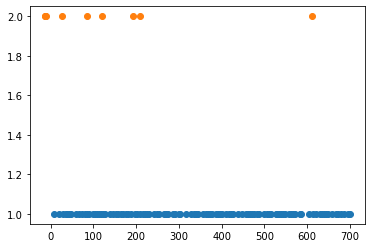

In [117]:
time_point_pull1 = np.round(time_point_pull1,2)
ind_plot = time_point_pull1 < (720 - session_start_time)
plt.plot(time_point_pull1[ind_plot], np.ones(np.shape(time_point_pull1[ind_plot])[0]),'o')
plt.plot(oneway_gaze1, np.ones(np.shape(oneway_gaze1)[0])*2,'o')
plt.plot(mutual_gaze1, np.ones(np.shape(mutual_gaze1)[0])*3,'o')

In [118]:
(time_point_eyecontact1+session_start_time)/60

array([ 0.09555556,  0.09722222,  0.75333333,  0.75388889,  1.72055556,
        2.31222222,  3.51      ,  3.76611111, 10.495     ])

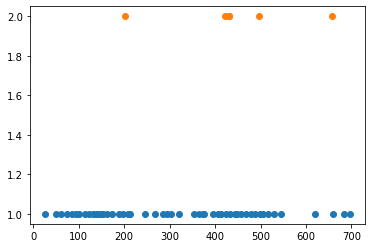

In [119]:
time_point_pull2 = np.round(time_point_pull2,2)
ind_plot = time_point_pull2 < (720 - session_start_time)
plt.plot(time_point_pull2[ind_plot], np.ones(np.shape(time_point_pull2[ind_plot])[0]),'o')
plt.plot(oneway_gaze2, np.ones(np.shape(oneway_gaze2)[0])*2,'o')
plt.plot(mutual_gaze2, np.ones(np.shape(mutual_gaze2)[0])*3,'o')

## plot behavioral results (with camera 23) and eye contact results

In [120]:
time_point_pull1 = bhv_data["time_points"][bhv_data["behavior_events"]==1]
time_point_pull2 = bhv_data["time_points"][bhv_data["behavior_events"]==2]
ind_lookatotherface1 = np.where(np.array(look_at_face_or_not_camera23[animal1])==1)
time_point_lookatotherface1 = look_at_face_or_not_camera23["time_in_second"][ind_lookatotherface1]
ind_lookatotherface2 = np.where(np.array(look_at_face_or_not_camera23[animal2])==1)
time_point_lookatotherface2 = look_at_face_or_not_camera23["time_in_second"][ind_lookatotherface2]

ind_eyecontact1 = np.where(np.array(eye_contact_or_not_camera23[animal1])==1)
time_point_eyecontact1 = eye_contact_or_not_camera23["time_in_second"][ind_eyecontact1]
ind_eyecontact2 = np.where(np.array(eye_contact_or_not_camera23[animal2])==1)
time_point_eyecontact2 = eye_contact_or_not_camera23["time_in_second"][ind_eyecontact2]

# calculate the oneway gaze or mutual gaze
animal1_gaze = np.round(np.concatenate((time_point_eyecontact1,time_point_lookatotherface1)),1)
animal1_gaze = np.unique(np.sort(animal1_gaze))
animal2_gaze = np.round(np.concatenate((time_point_eyecontact2,time_point_lookatotherface2)),1)
animal2_gaze = np.unique(np.sort(animal2_gaze))

ngaze1 = len(animal1_gaze)
ngaze2 = len(animal2_gaze)
oneway_gaze1 = []
oneway_gaze2 = []
mutual_gaze1 = []
mutual_gaze2 = []
# 
for igaze1 in np.arange(0, ngaze1, 1):
    for igaze2 in np.arange(0,ngaze2,1):
        if abs(animal1_gaze[igaze1]-animal2_gaze[igaze2])<1:
            mutual_gaze1.append(animal1_gaze[igaze1])
            mutual_gaze2.append(animal2_gaze[igaze2])
mutual_gaze1 = np.unique(mutual_gaze1)   
mutual_gaze2 = np.unique(mutual_gaze2)
oneway_gaze1 = animal1_gaze[~np.isin(animal1_gaze,mutual_gaze1)]
oneway_gaze2 = animal2_gaze[~np.isin(animal2_gaze,mutual_gaze2)]

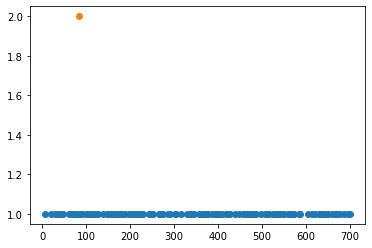

In [121]:
time_point_pull1 = np.round(time_point_pull1,2)
ind_plot = time_point_pull1 < (720 - session_start_time)
plt.plot(time_point_pull1[ind_plot], np.ones(np.shape(time_point_pull1[ind_plot])[0]),'o')
plt.plot(oneway_gaze1, np.ones(np.shape(oneway_gaze1)[0])*2,'o')
plt.plot(mutual_gaze1, np.ones(np.shape(mutual_gaze1)[0])*3,'o')

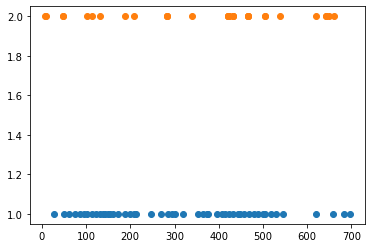

In [122]:
time_point_pull2 = np.round(time_point_pull2,2)
ind_plot = time_point_pull2 < (720 - session_start_time)
plt.plot(time_point_pull2[ind_plot], np.ones(np.shape(time_point_pull2[ind_plot])[0]),'o')
plt.plot(oneway_gaze2, np.ones(np.shape(oneway_gaze2)[0])*2,'o')
plt.plot(mutual_gaze2, np.ones(np.shape(mutual_gaze2)[0])*3,'o')